Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/05 20:42:20 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/10/05 20:42:20 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/10/05 20:42:20 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/10/05 20:42:20 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


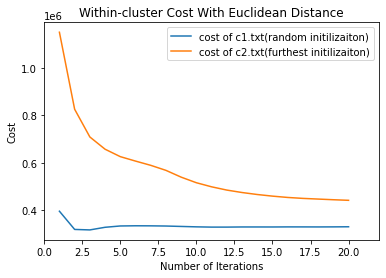

In [1]:
import operator
import sys
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from pyspark.mllib.feature import Normalizer
from sklearn.manifold import TSNE

# Macros.
MAX_ITER = 20
DATA_PATH = "gs://eecs6893_data/q1/data.txt"
C1_PATH = "gs://eecs6893_data/q1/c1.txt"
C2_PATH = "gs://eecs6893_data/q1/c2.txt"
NORM = 2

# Helper functions.
def closest(p, centroids, norm):
    """
    Compute closest centroid for a given point.
    Args:
        p (numpy.ndarray): input point
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        int: The index of closest centroid.
    """
    closest_c = min([(i, linalg.norm(p - c, norm))
                    for i, c in enumerate(centroids)],
                    key=operator.itemgetter(1))[0]
    return closest_c

# K-means clustering
def getCloestCentroid(pt, centroids, norm=2):
    c_index = closest(pt, centroids, norm)
    cost = linalg.norm(pt - centroids[c_index], norm)
    return (c_index, (pt, 1, cost))

def calculateCost(costData):
    totalCost, numPoints = 0, 0
    for cluster in costData:
        totalCost += cluster[1][2]
        numPoints += cluster[1][1]
    return totalCost

def kmeans(data, centroids, norm=2):
    """
    Conduct k-means clustering given data and centroid.
    This is the basic version of k-means, you might need more
    code to record cluster assignment to plot TSNE, and more
    data structure to record cost.
    Args:
        data (RDD): RDD of points
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        RDD: assignment information of points, a RDD of (centroid, (point, 1))
        list: a list of centroids
        and define yourself...
    """
    # iterative k-means
    cost = []
    for _ in range(MAX_ITER):
        # Transform each point to a combo of point, closest centroid, count=1
        # point -> (closest_centroid, (point, 1))
        clusters = data.map(lambda pt: getCloestCentroid(pt, centroids, norm)).reduceByKey(lambda count1, count2: \
        (count1[0] + count2[0], count1[1] + count2[1], count1[2] + count2[2]))
        # Re-compute cluster center
        # For each cluster center (key), aggregate its values
        centroids = clusters.map(lambda x: x[1][0]/x[1][1]).collect()
        # by summing up points and count
        # Average the points for each centroid: divide sum of points by count
        # Use collect() to turn RDD into list
        cost.append(calculateCost(clusters.collect()))
    return cost, centroids

def plotCost(c1, c2, distanceType, MAX_ITER):
    fig,ax1 = plt.subplots()
    x = list(range(1, MAX_ITER + 1))
    c1l = ax1.plot(x,c1,'-', label = f"cost of c1.txt(random initilizaiton)")
    c2l = ax1.plot(x,c2,'-', label = f"cost of c2.txt(furthest initilizaiton)")
    ax1.set_xlim(0, MAX_ITER + 2)
    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("Cost")
    ax1.legend()
    ax1.set_title(f"Within-cluster Cost With {distanceType} Distance")
    fig.show()

def tSNE(data, centroids, norm, plotTitle):
    def findCluster(pt, centroids, norm=2):
        c_index = closest(pt, centroids, norm)
        return (c_index)
    def plotTSNE(embeddedData, plotTitle, c=None):
        x = embeddedData[:, 0]
        y = embeddedData[:, 1]
        plt.scatter(x, y, c=c, cmap=plt.cm.get_cmap("jet", 10))
        plt.title(plotTitle)
        plt.show()
    dataClusters = data.map(lambda pt: findCluster(pt, centroids, norm))
    cluster = dataClusters.collect()    
    originalData = np.array(data.collect())
    orignalEmbeddedData = TSNE(n_components=2, random_state=100).fit_transform(originalData)
    plotTSNE(orignalEmbeddedData,plotTitle)
    plotTSNE(orignalEmbeddedData, plotTitle, cluster)

def main():
    # Spark settings
    conf = SparkConf()
    sc = SparkContext(conf=conf)

    # Load the data, cache this since we're accessing this each iteration
    data = sc.textFile(DATA_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).cache()
    # Load the initial centroids c1, split into a list of np arrays
    centroids1 = sc.textFile(C1_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).collect()
    # Load the initial centroids c2, split into a list of np arrays
    centroids2 = sc.textFile(C2_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).collect()

    # TODO: Run the kmeans clustering and complete the HW
    c1, centroids1Out = kmeans(data, centroids1, NORM)
    c2, centroids2Out = kmeans(data, centroids2, NORM)
    if NORM == 1:
        distanceType = "Manhattan"
    elif NORM == 2:
        distanceType = "Euclidean"
    plotCost(c1, c2, distanceType, MAX_ITER)
    # tSNE(data, centroids1Out, NORM, "t-SNE results of c1.txt using L2 distance and random_state=100")
    # tSNE(data, centroids2Out, NORM, "t-SNE results of c2.txt using L2 distance and random_state=100")

if __name__ == "__main__":
    main()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/05 20:44:28 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/10/05 20:44:28 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/10/05 20:44:28 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/10/05 20:44:28 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


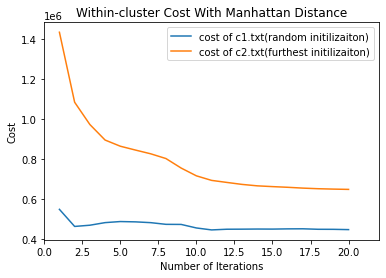

In [1]:
import operator
import sys
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from pyspark.mllib.feature import Normalizer
from sklearn.manifold import TSNE

# Macros.
MAX_ITER = 20
DATA_PATH = "gs://eecs6893_data/q1/data.txt"
C1_PATH = "gs://eecs6893_data/q1/c1.txt"
C2_PATH = "gs://eecs6893_data/q1/c2.txt"
NORM = 1

# Helper functions.
def closest(p, centroids, norm):
    """
    Compute closest centroid for a given point.
    Args:
        p (numpy.ndarray): input point
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        int: The index of closest centroid.
    """
    closest_c = min([(i, linalg.norm(p - c, norm))
                    for i, c in enumerate(centroids)],
                    key=operator.itemgetter(1))[0]
    return closest_c

# K-means clustering
def getCloestCentroid(pt, centroids, norm=2):
    c_index = closest(pt, centroids, norm)
    cost = linalg.norm(pt - centroids[c_index], norm)
    return (c_index, (pt, 1, cost))

def calculateCost(costData):
    totalCost, numPoints = 0, 0
    for cluster in costData:
        totalCost += cluster[1][2]
        numPoints += cluster[1][1]
    return totalCost

def kmeans(data, centroids, norm=2):
    """
    Conduct k-means clustering given data and centroid.
    This is the basic version of k-means, you might need more
    code to record cluster assignment to plot TSNE, and more
    data structure to record cost.
    Args:
        data (RDD): RDD of points
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        RDD: assignment information of points, a RDD of (centroid, (point, 1))
        list: a list of centroids
        and define yourself...
    """
    # iterative k-means
    cost = []
    for _ in range(MAX_ITER):
        # Transform each point to a combo of point, closest centroid, count=1
        # point -> (closest_centroid, (point, 1))
        clusters = data.map(lambda pt: getCloestCentroid(pt, centroids, norm)).reduceByKey(lambda count1, count2: \
        (count1[0] + count2[0], count1[1] + count2[1], count1[2] + count2[2]))
        # Re-compute cluster center
        # For each cluster center (key), aggregate its values
        centroids = clusters.map(lambda x: x[1][0]/x[1][1]).collect()
        # by summing up points and count
        # Average the points for each centroid: divide sum of points by count
        # Use collect() to turn RDD into list
        cost.append(calculateCost(clusters.collect()))
    return cost, centroids

def plotCost(c1, c2, distanceType, MAX_ITER):
    fig,ax1 = plt.subplots()
    x = list(range(1, MAX_ITER + 1))
    c1l = ax1.plot(x,c1,'-', label = f"cost of c1.txt(random initilizaiton)")
    c2l = ax1.plot(x,c2,'-', label = f"cost of c2.txt(furthest initilizaiton)")
    ax1.set_xlim(0, MAX_ITER + 2)
    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("Cost")
    ax1.legend()
    ax1.set_title(f"Within-cluster Cost With {distanceType} Distance")
    fig.show()

def tSNE(data, centroids, norm, plotTitle):
    def findCluster(pt, centroids, norm=2):
        c_index = closest(pt, centroids, norm)
        return (c_index)
    def plotTSNE(embeddedData, plotTitle, c=None):
        x = embeddedData[:, 0]
        y = embeddedData[:, 1]
        plt.scatter(x, y, c=c, cmap=plt.cm.get_cmap("jet", 10))
        plt.title(plotTitle)
        plt.show()
    dataClusters = data.map(lambda pt: findCluster(pt, centroids, norm))
    cluster = dataClusters.collect()    
    originalData = np.array(data.collect())
    orignalEmbeddedData = TSNE(n_components=2, random_state=100).fit_transform(originalData)
    plotTSNE(orignalEmbeddedData,plotTitle)
    plotTSNE(orignalEmbeddedData, plotTitle, cluster)

def main():
    # Spark settings
    conf = SparkConf()
    sc = SparkContext(conf=conf)

    # Load the data, cache this since we're accessing this each iteration
    data = sc.textFile(DATA_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).cache()
    # Load the initial centroids c1, split into a list of np arrays
    centroids1 = sc.textFile(C1_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).collect()
    # Load the initial centroids c2, split into a list of np arrays
    centroids2 = sc.textFile(C2_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).collect()

    # TODO: Run the kmeans clustering and complete the HW
    c1, centroids1Out = kmeans(data, centroids1, NORM)
    c2, centroids2Out = kmeans(data, centroids2, NORM)
    if NORM == 1:
        distanceType = "Manhattan"
    elif NORM == 2:
        distanceType = "Euclidean"
    plotCost(c1, c2, distanceType, MAX_ITER)
    # tSNE(data, centroids1Out, NORM, "t-SNE results of c1.txt using L2 distance and random_state=100")
    # tSNE(data, centroids2Out, NORM, "t-SNE results of c2.txt using L2 distance and random_state=100")

if __name__ == "__main__":
    main()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/02 22:56:53 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/10/02 22:56:53 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/10/02 22:56:53 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/10/02 22:56:53 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


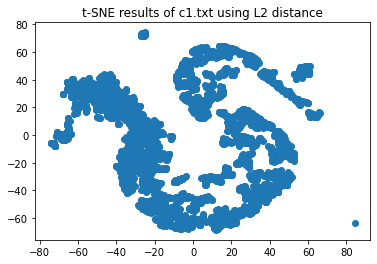

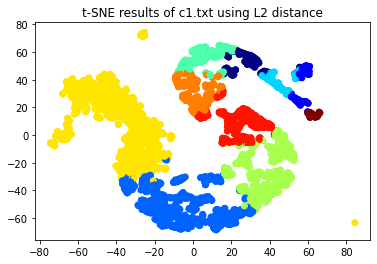

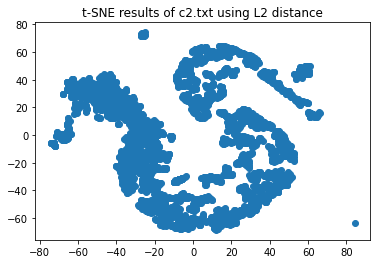

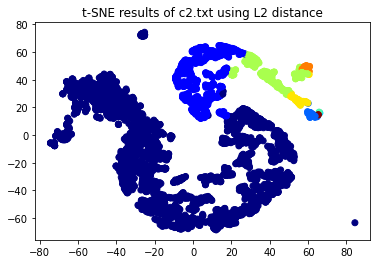

In [1]:
import operator
import sys
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from pyspark.mllib.feature import Normalizer
from sklearn.manifold import TSNE

# Macros.
MAX_ITER = 20
DATA_PATH = "gs://eecs6893_data/q1/data.txt"
C1_PATH = "gs://eecs6893_data/q1/c1.txt"
C2_PATH = "gs://eecs6893_data/q1/c2.txt"
NORM = 2

# Helper functions.
def closest(p, centroids, norm):
    """
    Compute closest centroid for a given point.
    Args:
        p (numpy.ndarray): input point
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        int: The index of closest centroid.
    """
    closest_c = min([(i, linalg.norm(p - c, norm))
                    for i, c in enumerate(centroids)],
                    key=operator.itemgetter(1))[0]
    return closest_c

# K-means clustering
def getCloestCentroid(pt, centroids, norm=2):
    c_index = closest(pt, centroids, norm)
    cost = linalg.norm(pt - centroids[c_index], norm)
    return (c_index, (pt, 1, cost))

def calculateCost(costData):
    totalCost, numPoints = 0, 0
    for cluster in costData:
        totalCost += cluster[1][2]
        numPoints += cluster[1][1]
    return totalCost / numPoints

def kmeans(data, centroids, norm=2):
    """
    Conduct k-means clustering given data and centroid.
    This is the basic version of k-means, you might need more
    code to record cluster assignment to plot TSNE, and more
    data structure to record cost.
    Args:
        data (RDD): RDD of points
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        RDD: assignment information of points, a RDD of (centroid, (point, 1))
        list: a list of centroids
        and define yourself...
    """
    # iterative k-means
    cost = []
    for _ in range(MAX_ITER):
        # Transform each point to a combo of point, closest centroid, count=1
        # point -> (closest_centroid, (point, 1))
        clusters = data.map(lambda pt: getCloestCentroid(pt, centroids, norm)).reduceByKey(lambda count1, count2: \
        (count1[0] + count2[0], count1[1] + count2[1], count1[2] + count2[2]))
        # Re-compute cluster center
        # For each cluster center (key), aggregate its values
        centroids = clusters.map(lambda x: x[1][0]/x[1][1]).collect()
        # by summing up points and count
        # Average the points for each centroid: divide sum of points by count
        # Use collect() to turn RDD into list
        cost.append(calculateCost(clusters.collect()))
    return cost, centroids

def plotCost(cost, distanceType, initialCluster, MAX_ITER):
    fig,ax1 = plt.subplots()
    x = list(range(1, MAX_ITER + 1))
    ax1.plot(x,cost,'-')
    ax1.set_xlim(0, MAX_ITER + 2)
    ax1.set_xlabel('Number of Iterations')
    ax1.set_ylabel('Cost')
    ax1.set_title(f'Within-cluster Cost With {distanceType} Distance and {initialCluster} Initialization')
    fig.show()

def tSNE(data, centroids, norm, plotTitle):
    def findCluster(pt, centroids, norm=2):
        c_index = closest(pt, centroids, norm)
        return (c_index)
    def plotTSNE(embeddedData, plotTitle, c=None):
        x = embeddedData[:, 0]
        y = embeddedData[:, 1]
        plt.scatter(x, y, c=c, cmap=plt.cm.get_cmap("jet", 10))
        plt.title(plotTitle)
        plt.show()
    dataClusters = data.map(lambda pt: findCluster(pt, centroids, norm))
    cluster = dataClusters.collect()    
    originalData = np.array(data.collect())
    orignalEmbeddedData = TSNE(n_components=2, random_state=100).fit_transform(originalData)
    plotTSNE(orignalEmbeddedData,plotTitle)
    plotTSNE(orignalEmbeddedData, plotTitle, cluster)

def main():
    # Spark settings
    conf = SparkConf()
    sc = SparkContext(conf=conf)

    # Load the data, cache this since we're accessing this each iteration
    data = sc.textFile(DATA_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).cache()
    # Load the initial centroids c1, split into a list of np arrays
    centroids1 = sc.textFile(C1_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).collect()
    # Load the initial centroids c2, split into a list of np arrays
    centroids2 = sc.textFile(C2_PATH).map(
            lambda line: np.array([float(x) for x in line.split(' ')])
            ).collect()

    # TODO: Run the kmeans clustering and complete the HW
    c1, centroids1Out = kmeans(data, centroids1, NORM)
    c2, centroids2Out = kmeans(data, centroids2, NORM)
    if NORM == 1:
        distanceType = "Manhattan"
    elif NORM == 2:
        distanceType = "Euclidean"
    # plotCost(c1, distanceType, "Randomized", MAX_ITER)
    # plotCost(c2, distanceType, "Furthest", MAX_ITER)
    tSNE(data, centroids1Out, NORM, "t-SNE results of c1.txt using L2 distance")
    tSNE(data, centroids2Out, NORM, "t-SNE results of c2.txt using L2 distance")

if __name__ == "__main__":
    main()